In [1]:
import torch
import torchani
from torchani.datasets import ANIDataset
from torchani.units import hartree2kcalmol
from torchani.utils import PERIODIC_TABLE
import ase
from ase import io
from ase.optimize import BFGS
from ase.visualize import view

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pathlib import Path

In [5]:
device = torch.device('cpu')
ani2x = torchani.models.ANI2x().double()
calculator = torchani.models.ANI2x().ase()
path = Path('/home/nick/QE/c5h12.xyz')

In [6]:
def tensors_from_xyz(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        num_atoms = int(lines[0])
        coordinates = []
        species = []
        element, a, b, c = lines[2].split()
        cell = torch.diag(torch.tensor([float(a), float(b), float(c)]))
        for line in lines[2:]:
            values = line.split()
            if values:
                s = values[0].strip()
                x = float(values[1])
                y = float(values[2])
                z = float(values[3])
                coordinates.append([x, y, z])
                species.append(PERIODIC_TABLE.index(s))
        coordinates = torch.tensor(coordinates)
        species = torch.tensor(species, dtype=torch.long)
        assert coordinates.shape[0] == num_atoms
        assert species.shape[0] == num_atoms
    return species, coordinates



def covariances(atomic_energies):
    atomic_energies = atomic_energies.squeeze()
    cov = np.cov(atomic_energies,rowvar=False)
    atomic_variances = cov.diagonal()
    av_sum = atomic_variances.sum()
    atomic_stdev = np.sqrt(atomic_variances)
    estimated_qbc = np.sqrt(sum(sum(cov)))/np.sqrt(len(atomic_variances))
    
    just_covariances = estimated_qbc - np.sum(atomic_variances)
    
    qbc = atomic_energies.sum(1).std(0,ddof=1)/np.sqrt(len(atomic_variances)) # TorchANI uses unbiased stdev, so N-1
    
    
    assert math.isclose(qbc, estimated_qbc, abs_tol=0.0002) # Tolerance set to agree within 0.0002 Hartree (~.12 kcal/mol))

    print('(1) Atomic energy variance', '(2) Covariances', '(3) QBC')
    
    return av_sum, just_covariances, qbc

device = torch.device('cpu')
model = torchani.models.ANI2x(periodic_table_index=True).double().to(device)
calculator = model.ase()

In [7]:
tensors_from_xyz(path)[1]

tensor([[-1.5932,  0.4758, -0.0000],
        [-0.0579,  0.4758, -0.0000],
        [-2.1050, -0.7266,  0.8059],
        [-2.1050,  0.3792, -1.4443],
        [-2.1050,  1.7750,  0.6384],
        [-1.7553, -0.5400, -1.9276],
        [-1.7553,  1.2258, -2.0458],
        [-3.2003,  0.3770, -1.4770],
        [-1.7553, -1.6708,  0.3734],
        [-3.2003, -0.7538,  0.8241],
        [-1.7553, -0.6856,  1.8436],
        [ 0.3381, -0.4412, -0.4507],
        [ 0.3381,  0.5441,  1.0195],
        [ 0.3381,  1.3246, -0.5688],
        [-1.7553,  1.8726,  1.6724],
        [-3.2003,  1.8043,  0.6529],
        [-1.7553,  2.6531,  0.0840]])

In [8]:
ase_c5h12 = ase.Atoms(numbers=tensors_from_xyz(path)[0],positions=tensors_from_xyz(path)[1])
ase_c5h12.calc = calculator
#print(ase_c5h12.positions)

dyn = BFGS(ase_c5h12)
dyn.run(fmax=0.05)

c5h12_coord = torch.tensor(ase_c5h12.positions[None])

#print(ase_c5h12.positions)

      Step     Time          Energy         fmax
BFGS:    0 08:24:58    -5380.198751        0.0880
BFGS:    1 08:24:58    -5380.199213        0.0230


In [9]:
c5h12 = (torch.tensor(ase_c5h12.numbers)[None], torch.tensor(ase_c5h12.positions)[None])
print(c5h12)

(tensor([[6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), tensor([[[-1.5932e+00,  4.7584e-01,  2.1798e-07],
         [-5.9158e-02,  4.7584e-01,  1.5060e-06],
         [-2.1046e+00, -7.2565e-01,  8.0521e-01],
         [-2.1046e+00,  3.7925e-01, -1.4431e+00],
         [-2.1046e+00,  1.7739e+00,  6.3790e-01],
         [-1.7550e+00, -5.4058e-01, -1.9276e+00],
         [-1.7550e+00,  1.2263e+00, -2.0459e+00],
         [-3.2009e+00,  3.7700e-01, -1.4767e+00],
         [-1.7550e+00, -1.6712e+00,  3.7303e-01],
         [-3.2009e+00, -7.5361e-01,  8.2395e-01],
         [-1.7550e+00, -6.8533e-01,  1.8441e+00],
         [ 3.3801e-01, -4.4174e-01, -4.5092e-01],
         [ 3.3801e-01,  5.4412e-01,  1.0201e+00],
         [ 3.3801e-01,  1.3251e+00, -5.6919e-01],
         [-1.7550e+00,  1.8724e+00,  1.6729e+00],
         [-3.2009e+00,  1.8041e+00,  6.5275e-01],
         [-1.7550e+00,  2.6534e+00,  8.3564e-02]]], dtype=torch.float64))


In [10]:
c5h12_ae = hartree2kcalmol(ani2x.atomic_energies(c5h12,average=False,with_SAEs=False).energies.squeeze().detach().numpy())
print(c5h12_ae)

[[-18.59805392  -6.94893571  -6.9489808   -6.94902916  -6.94903172
   -1.24722554  -1.24718876  -1.24720134  -1.24723034  -1.24718001
   -1.24724038  -1.24718502  -1.2472481   -1.24720341  -1.24718801
   -1.24720626  -1.24722569]
 [-14.71264796   9.37439511   9.37432583   9.37430525   9.37429801
   -6.97495137  -6.97492934  -6.97495041  -6.97495922  -6.97490872
   -6.97497065  -6.97491906  -6.9749892   -6.97493518  -6.97491886
   -6.97494314  -6.97497036]
 [-20.81018951   0.2088058    0.20874065   0.2087092    0.20870851
   -3.45832198  -3.45830646  -3.45832568  -3.45833624  -3.45829478
   -3.45834611  -3.45830036  -3.45836038  -3.45831815  -3.45829724
   -3.4583208   -3.45834193]
 [-24.44036432  -5.81439941  -5.81445231  -5.81448059  -5.81448955
   -1.12949     -1.12944351  -1.12945995  -1.12948315  -1.12943587
   -1.12949564  -1.12944043  -1.1295064   -1.12945306  -1.1294459
   -1.1294638   -1.12948117]
 [-16.58558883  -6.36363555  -6.36370223  -6.3637289   -6.3637432
   -1.62909254 

In [11]:
c5h12_ae.shape

(8, 17)

In [12]:
c5h12_ae.sum(1).std(0,ddof=1)

0.2940834253134049

In [13]:
hartree2kcalmol(ani2x.energies_qbcs(c5h12).qbcs.item()*math.sqrt(5))
# Equal up to float rounding precision

0.15948913022548517

In [14]:
print(covariances(c5h12_ae))

(1) Atomic energy variance (2) Covariances (3) QBC
(172.5871239195329, -172.51579821216168, 0.07132570737121241)


In [15]:
c5h12_ae

array([[-18.59805392,  -6.94893571,  -6.9489808 ,  -6.94902916,
         -6.94903172,  -1.24722554,  -1.24718876,  -1.24720134,
         -1.24723034,  -1.24718001,  -1.24724038,  -1.24718502,
         -1.2472481 ,  -1.24720341,  -1.24718801,  -1.24720626,
         -1.24722569],
       [-14.71264796,   9.37439511,   9.37432583,   9.37430525,
          9.37429801,  -6.97495137,  -6.97492934,  -6.97495041,
         -6.97495922,  -6.97490872,  -6.97497065,  -6.97491906,
         -6.9749892 ,  -6.97493518,  -6.97491886,  -6.97494314,
         -6.97497036],
       [-20.81018951,   0.2088058 ,   0.20874065,   0.2087092 ,
          0.20870851,  -3.45832198,  -3.45830646,  -3.45832568,
         -3.45833624,  -3.45829478,  -3.45834611,  -3.45830036,
         -3.45836038,  -3.45831815,  -3.45829724,  -3.4583208 ,
         -3.45834193],
       [-24.44036432,  -5.81439941,  -5.81445231,  -5.81448059,
         -5.81448955,  -1.12949   ,  -1.12944351,  -1.12945995,
         -1.12948315,  -1.12943587,


QBC from ANI (w/o dividing by N_atoms):
 0.2940834253137671 (Hartree)
Sqrt of the sum over entire covariance matrix:
 0.29408342531342313 (Hartree)


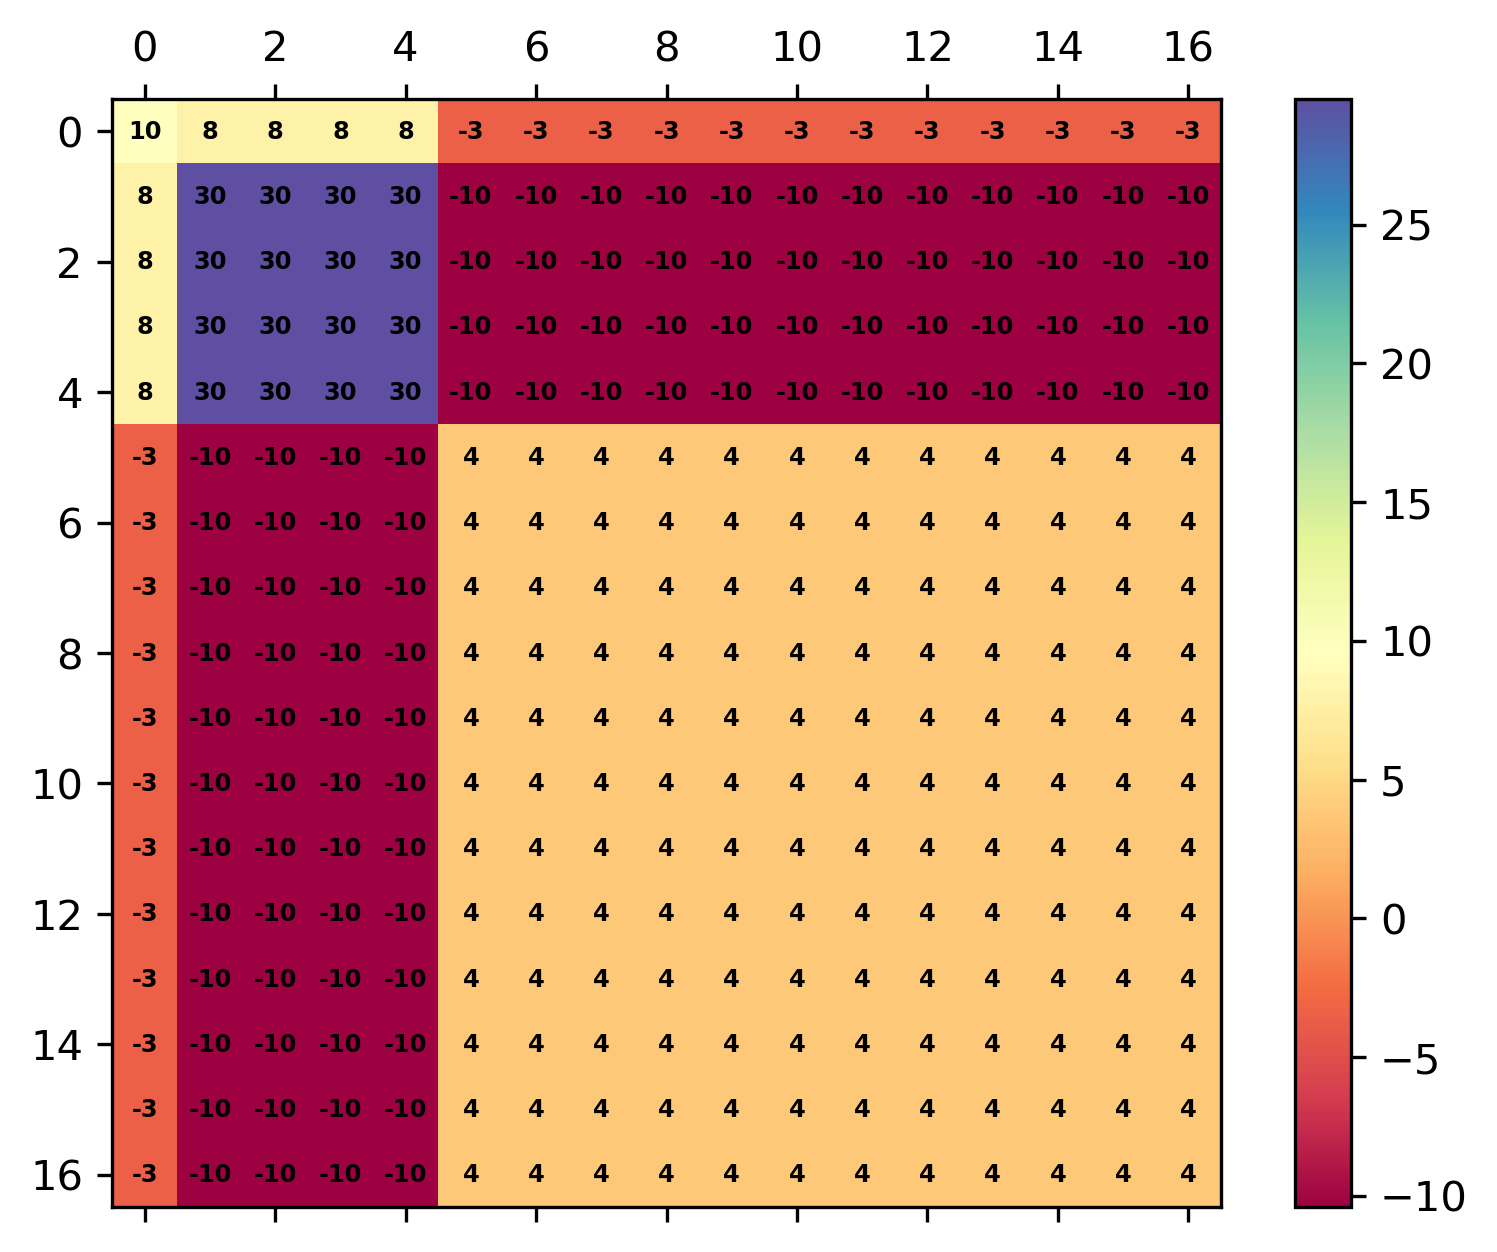

In [21]:
c5h12_cov = np.cov(c5h12_ae,rowvar=False)
#print('Covariance matrix:\n',pd.DataFrame(c5h12_cov))
atomic_variances = c5h12_cov.diagonal()
atomic_stdev = np.sqrt(atomic_variances)
#print()
#print('AE variance (stdev squared):\n',atomic_variances)
#print('AE stdev:\n',atomic_stdev)
print()

sqrt_sum_cov = np.sqrt(sum(sum(c5h12_cov)))
c5h12_qbc = hartree2kcalmol(ani2x.members_energies(c5h12)[1].std(0).detach().numpy()[0])
only_covariances = sqrt_sum_cov - np.sum(atomic_variances)

#print('Sum of covariances (off-diagonal elements):\n',only_covariances)

print('QBC from ANI (w/o dividing by N_atoms):\n',c5h12_qbc,'(Hartree)')
print('Sqrt of the sum over entire covariance matrix:\n',sqrt_sum_cov,'(Hartree)')

plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()
img = ax.matshow(c5h12_cov, cmap='Spectral')
fig.colorbar(img)

for (i, j), z in np.ndenumerate(c5h12_cov):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center',fontsize='xx-small',fontweight='black')

In [31]:
hartree2kcalmol(0.0004656158585728322/math.sqrt(17))

0.07086366175837465

In [51]:
print('Mol_E stdev:',ani2x.energies_qbcs(ch4).qbcs.item()*math.isqrt(5))
print('Atom_E stdev:',torch.tensor(ch4_ae).std(0, unbiased=True))
print('Sum of AE_std:',torch.tensor(ch4_ae).std(0, unbiased=True).sum(0))
print()
print('Covariance matrix:\n',cov(ch4_ae))
print('Diagonal of cov matrix:\n',(cov(ch4_ae).diagonal())) # This gives "variances"


Mol_E stdev: 0.00019029963373543365
Atom_E stdev: tensor([0.0127, 0.0032, 0.0032, 0.0032, 0.0032], dtype=torch.float64)
Sum of AE_std: tensor(0.0254, dtype=torch.float64)

Covariance matrix:
 [[ 1.12333322e-03 -2.82624944e-04 -2.82549934e-04 -2.82355571e-04
  -2.82682503e-04]
 [-2.82624944e-04  7.11254475e-05  7.11050677e-05  7.10567597e-05
   7.11395954e-05]
 [-2.82549934e-04  7.11050677e-05  7.10852361e-05  7.10366677e-05
   7.11193529e-05]
 [-2.82355571e-04  7.10567597e-05  7.10366677e-05  7.09882766e-05
   7.10709617e-05]
 [-2.82682503e-04  7.11395954e-05  7.11193529e-05  7.10709617e-05
   7.11537837e-05]]
Diagonal of cov matrix:
 [1.12333322e-03 7.11254475e-05 7.10852361e-05 7.09882766e-05
 7.11537837e-05]
